In [21]:
import numpy as np
import time
import scipy.stats as stats
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats

# Extracting data of particular periods of interest

In [2]:
data = pd.read_sas('/home/guangya/Downloads/wnv_2245new.sas7bdat') #Data from week 22 to 45, which is what i used for latter models

In [101]:
x = data[['yr','templag2','templag3','templag4','precilag2','mirlag1','mirlag2','mirlag3','mirlag4', 'whitepct','owpct','dmipct','dhipct']].values 
y = data['wnvbinary'].values 
# Data set for the best model described in paper, table5.
x = x.astype('float64')

In [102]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.2, shuffle = True) # CV

In [34]:
data_mid_summer = data[data['weeks'] <= 33]
data_mid_summer = data_mid_summer[data_mid_summer['weeks'] >= 28]
# Data set for the mid-summer only, maybe used later

# Random Forest

In [115]:
def model_RF_test(model_RF, dataX, dataY):
    print("Model performance")
    predict_data = model_RF.predict(dataX)
    
    # Some stats
    print("precision,recall,and fscore", metrics.precision_recall_fscore_support(dataY, predict_data, average='macro'))
    
#     plt.figure(1)
#     plt.xlabel('labels')
#     plt.ylabel('counts')
    
#     plt.figure(1)
#     plt.xlabel('True MIR')
#     plt.ylabel('Predicted MIR')
#     plt.plot(dataY, predict_data, "*")
#     plt.show()
    
#     plt.figure(2)
#     plt.plot(dataY, label = 'actual data')
#     plt.plot(predict_data, label = 'predict data')
#     plt.xlabel('Tract')
#     plt.ylabel('MIR')
#     plt.legend(loc = 'best')
#     plt.show()
    
    return sum(predict_data) # Check how many wnv it predicts

In [34]:
# A reminder: When I tried to use MAE as the criterion of RandomForestRegressor, I found that it took so much time,
# and that's beacuase the scikilt-learn::RandomForest package has some problems when dealing with MAE.
# The discuss link is: https://github.com/scikit-learn/scikit-learn/issues/9626
# This problem is stil not solved. If you are interested, you can take part in solving that through this link.
# Currently, MAE took N(O^2) time, so be careful to use that.

In [103]:
dataX = trainX
dataY = trainY
time_start = time.time()
model_RF1 = RandomForestClassifier(n_estimators=100,
                                 n_jobs = -1,
                                 max_features="sqrt",
                                 max_depth= None,
                                 bootstrap=True,
                                class_weight='balanced'
                                 ) # Model with 100 trees, class weight is balanced to address the highly unbalanced data set
model_RF1.fit(dataX, dataY)
print("time consumed:", time.time() - time_start)

time consumed: 124.7069685459137


In [117]:
model_RF_test(model_RF1,testX,testY) # Can not generalize well on test data

Model performance
precision,recall,and fscore (0.49969548065610075, 0.5, 0.49984769394791134, None)


/home/guangya/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [118]:
model_RF_test(model_RF1,dataX,dataY) # Fit vert well on training data, but this is expected

Model performance
precision,recall,and fscore (0.9999987015235456, 0.997913769123783, 0.9989540545936825, None)


716.0

In [119]:
model_RF_test(model_RF1,x,y) # Only fit the training data

Model performance
precision,recall,and fscore (0.9999380271157334, 0.9, 0.9444134560818731, None)


716.0

In [120]:
time_start = time.time()
model_RF2 = RandomForestClassifier(n_estimators=200,
                                 n_jobs = -1,
                                 max_features="sqrt",
                                 max_depth= None,
                                 bootstrap=True,
                                class_weight='balanced'
                                 ) # Try more trees
model_RF2.fit(dataX, dataY)
print("time consumed:", time.time() - time_start)

time consumed: 241.3777256011963


In [121]:
model_RF_test(model_RF2,testX,testY)

Model performance
precision,recall,and fscore (0.49969548065610075, 0.5, 0.49984769394791134, None)


/home/guangya/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [122]:
model_RF_test(model_RF2,dataX,dataY)

Model performance
precision,recall,and fscore (1.0, 1.0, 1.0, None)


719.0

In [123]:
model_RF_test(model_RF2,x,y) # Same as the model above, but fits the training perfectly

Model performance
precision,recall,and fscore (0.999939065640846, 0.9016759776536313, 0.9454466065524114, None)


719.0

In [214]:
model_RF2.feature_importances_ # mir lag seems to be the most important features 

array([0.02491376, 0.09101957, 0.1005739 , 0.09984618, 0.04523282,
       0.11345282, 0.15749454, 0.1207259 , 0.08186676, 0.04307836,
       0.02166634, 0.05898916, 0.04113991])

In [132]:
ypred_prob = model_RF2.predict_proba(testX)

In [135]:
ypred_prob[ypred_prob[:,1] > 0] # Check the probability, want to see if this provides some insights

array([[0.99 , 0.01 ],
       [0.99 , 0.01 ],
       [0.995, 0.005],
       ...,
       [0.995, 0.005],
       [0.955, 0.045],
       [0.995, 0.005]])

In [156]:
testY[np.where(ypred_prob[:,1]  > 0.1)].sum() 

1.0

In [157]:
len(ypred_prob[ypred_prob[:,1]  > 0.1]) # 1 out of 19 are predicted with probability of ~ 0.1

19

In [158]:
testY[np.where(ypred_prob[:,1]  > 0.01)].sum() 

21.0

In [159]:
len(ypred_prob[ypred_prob[:,1]  > 0.01]) #  21 out of 2721 are predicted, with probability of ~ 0.01, which is sort of expceted

2723

In [198]:
ypred_prob[ypred_prob[:,1] > 0][:,1].mean() # The probability is ~ 0.01

0.009424154650210945

In [200]:
len(ypred_prob[ypred_prob[:,1]  > 0]) # rows that has a non-zero probability

15881

In [202]:
len(ypred_prob) # total rows

288980

In [201]:
testY[np.where(ypred_prob[:,1]  > 0)].sum() # This should be about 150, this is not good but promising?

58.0

In [203]:
testY.sum() # This is certainly a pattern here since about 1/3 of all wnv binary are found from about 1/20 of the data

176.0

In [173]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

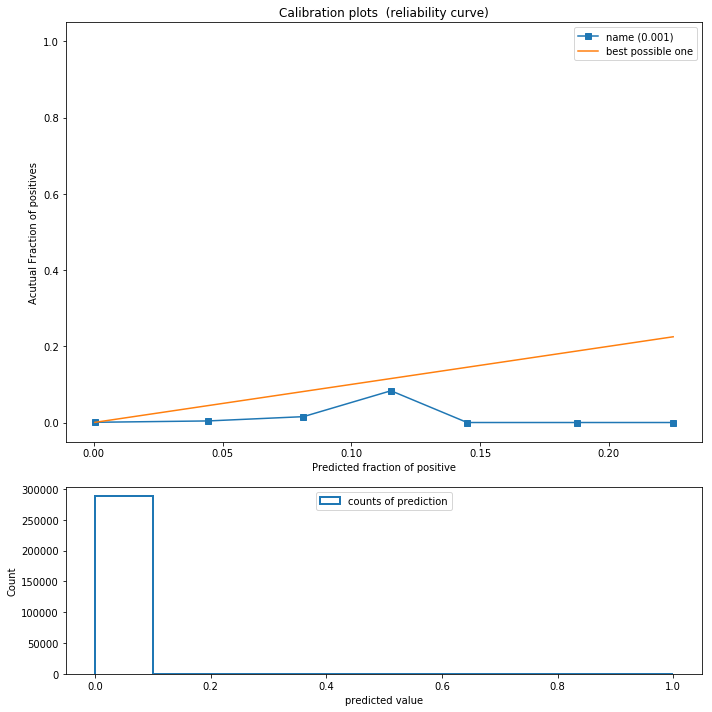

In [251]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
clf_score = brier_score_loss(testY, ypred_prob[:,1], pos_label=1)
fraction_of_positives, mean_predicted_value = \
    calibration_curve(testY, ypred_prob[:,1], n_bins=30)
# x_temp = np.linspace(0,0.3,100)
# y_temp = x
# ax1.plot(x, y, '-r', label='y=x, the best possible curve')
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s (%1.3f)" % ('name', clf_score))
ax1.plot(mean_predicted_value,mean_predicted_value,label = "best possible one")
ax1.set_xlabel("Predicted fraction of positive")
ax2.hist(ypred_prob[:,1], range=(0, 1), bins=10, label='counts of prediction',
         histtype="step", lw=2)
ax1.set_ylabel("Acutual Fraction of positives")
ax1.set_ylim([-0.05, 1.05])

ax1.legend(loc="upper right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [215]:
time_start = time.time()
model_RF3 = RandomForestClassifier(n_estimators=400,
                                 n_jobs = -1,
                                 max_features=None,
                                 max_depth= None,
                                 bootstrap=True,
                                class_weight='balanced'
                                 ) # Try more trees and see if calibration curve gets better
model_RF3.fit(dataX, dataY)
print("time consumed:", time.time() - time_start) 

time consumed: 1598.0512900352478


In [216]:
ypred_prob3 =  model_RF3.predict_proba(testX)

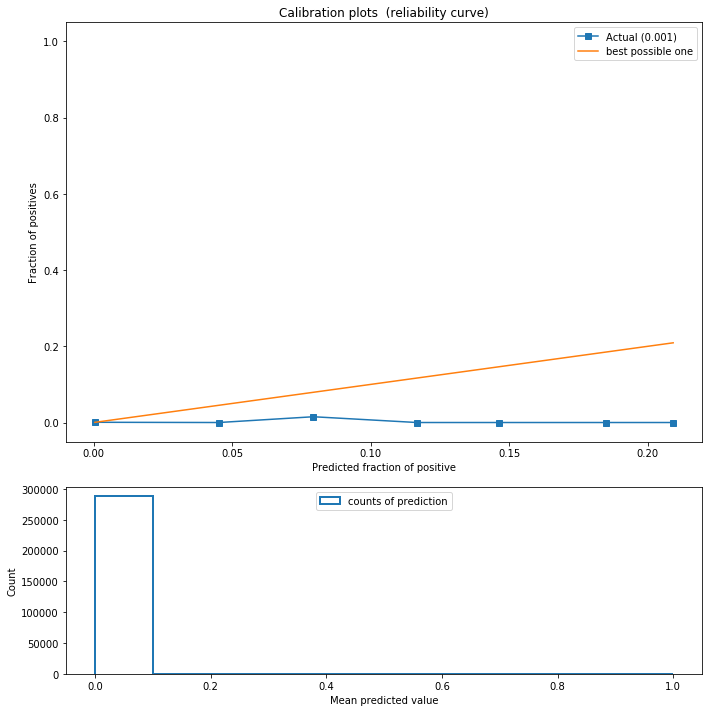

In [250]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
clf_score = brier_score_loss(testY, ypred_prob3[:,1], pos_label=1)
fraction_of_positives, mean_predicted_value = \
    calibration_curve(testY, ypred_prob3[:,1], n_bins=30)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s (%1.3f)" % ('Actual', clf_score))
ax1.plot(mean_predicted_value,mean_predicted_value,label = "best possible one")
ax1.set_xlabel("Predicted fraction of positive")
ax2.hist(ypred_prob3[:,1], range=(0, 1), bins=10, label='counts of prediction',
         histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [228]:
testY[np.where(ypred_prob3[:,1]  > 0.1)].sum()  # Try same procedure as the above model

0.0

In [229]:
len(ypred_prob3[ypred_prob3[:,1]  > 0.1])

38

In [230]:
testY[np.where(ypred_prob3[:,1]  > 0.01)].sum() 

27.0

In [231]:
len(ypred_prob3[ypred_prob3[:,1]  > 0.01])

3541

In [232]:
ypred_prob3[ypred_prob3[:,1] > 0][:,1].mean() # average probability of prediction that is > 0

0.007192275574112736

In [233]:
len(ypred_prob3[ypred_prob3[:,1]  > 0]) #  # of prediction that is > 0

23950

In [235]:
len(ypred_prob3)# total rows

288980

In [236]:
testY.sum()  #  # of wnv occurence

176.0

In [237]:
testY[np.where(ypred_prob3[:,1]  > 0)].sum() # For all wnv predicted probability > 0, how many are atucally 1

87.0

In [239]:
# With more tree, it has a worse looking calibaration curves, but it is able to capture more wnv binary. This is mostly because there are few points that is greater than 0.1, so
# there is a lot of variance here.

# Pipnelines for later for wrok

## Find best model 1

In [39]:
time_start = time.time()
params_RF_grid_1 = {
    'n_estimators' : [500, 1000],
    'max_features' : [90, 'sqrt', None],
    'max_depth' : [10, None],
    'min_samples_leaf' : [1,2]
}
CV_model_RF_1 = GridSearchCV(model_RF, params_RF_grid_1, cv=5)
CV_model_RF_1.fit(dataX, dataY)
print("time consumed:", time.time() - time_start)

time consumed: 6569.04248213768


In [40]:
CV_model_RF_1.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [41]:
CV_model_RF_1.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'n_estimators': 1000}

In [37]:
time_start = time.time()
model_RF_best_1 = RandomForestRegressor(n_estimators=1000,
                                 criterion="mse",
                                 n_jobs = -1,
                                 max_features="sqrt",
                                 max_depth=None,
                                 bootstrap=True,
                                 min_samples_leaf=2
                                 )
model_RF_best_1.fit(trainX, trainY)
print("Time consumed:", time.time() - time_start)

Time consumed: 3.5605108737945557


## Find best model 2

In [ ]:
time_start = time.time()
params_RF_grid_2 = {
    'n_estimators' : [800, 1200],
    'max_features' : ['sqrt', 5],
    'min_samples_leaf' : [2,3]
}
CV_model_RF_2 = GridSearchCV(model_RF, params_RF_grid_2, cv=5)
CV_model_RF_2.fit(dataX, dataY)
print("time consumed:", time.time() - time_start)

In [24]:
CV_model_RF_2.fit(dataX, dataY)

KeyboardInterrupt: 

In [ ]:
CV_model_RF_2.best_params_

In [11]:
time_start = time.time()
model_RF_best_2 = RandomForestRegressor(n_estimators=1500,
                                 criterion="mse",
                                 n_jobs = -1,
                                 max_features=None,
                                 max_depth=None,
                                 bootstrap=True,
                                 min_samples_leaf=2
                                 )
model_RF_best_2.fit(trainX, trainY)
print("Time consumed:", time.time() - time_start)

Time consumed: 263.9204020500183


## Find best model 3

In [12]:
time_start = time.time()
params_RF_grid_3 = {
    'n_estimators' : [1500, 3000],
    'max_features' : ['sqrt', 'log2'],
    'min_samples_leaf' : [2,4]
}
CV_model_RF_3 = GridSearchCV(model_RF_best_2, params_RF_grid_3, cv=5)
CV_model_RF_3.fit(dataX, dataY)
print("time consumed:", time.time() - time_start)

time consumed: 998.9455091953278


In [13]:
CV_model_RF_3.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=3000,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [14]:
CV_model_RF_3.best_params_

{'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 3000}

In [51]:
time_start = time.time()
model_RF_best_3 = RandomForestRegressor(n_estimators=8000,
                                 criterion="mse",
                                 n_jobs = -1,
                                 max_features="log2",
                                 max_depth=None,
                                 bootstrap=True,
                                 min_samples_leaf=2
                                 )
model_RF_best_3.fit(trainX, trainY)
print("Time consumed:", time.time() - time_start)

Time consumed: 45.644662857055664
